# Determine the accuracy of the radius of gyration on polymer sampling efficiency

The point of this notebook is two-fold: it will find the valid range of parameters for the simulation algorithm used in this work and it will explore how accurate the radius of gyration is when determined from a down-sampled version of a polymer. This will partly determine the accuracy in determining R<sub>g</sub> from a constellation of fluorophore localizations, which is what is done in this work.

The simulation algorithm has a range of valid parameters because it was developed from an analytical simplification: namely, the tangent-tangent correlation function is approximated by throwing away terms higher than second order in the cosine expansion. This suggests that the root-mean-square radius of gyration from a population of polymers will differ from the theoertical expression. The difference should get worse as the chain gets longer because the errors will accrue with multiple chain segments.

The next step will be to test the accuracy of estimating a polymer chain's radius of gyration from a constellation of localizations that sparsely label the same chain.

The approach will be to create a large number of polymers from very small line segments using the algorithm already developed to perform the maximum likelihood estimations. Then, a downsampled version of the same polymers will be made by randomly selecting segments to keep and throwing away the rest.

The radius of gyration for each will be computed and compared to the theoretical value. This should also answer the question of how many localizations are needed to determine R<sub>g</sub> to a given degree of accuracy.

## Setup the environment

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Random walk polymer code
import rw
import rw_helpers

# Inline plotting
%matplotlib inline

In [2]:
# What polymer parameters should be simulated? (packing ratio [bp/nm], persistence length [nm])
#params = [(20, 20), (30, 50), (30, 60), (40, 75), (50, 100), (75, 100), (100, 100)]
params = [(1,50), (2, 50), (5, 50), (10, 50), (20, 50), (50, 50), (100, 50)]

# Length of chains in base pairs (close to the real Hela S and Hela L values)
numBP = {'Hela L' : 2.5e4,
         'Hela S' : 1e4}

## Find the bias in Rg as a function of packing ratio

Previous tests have shown that the accuracy in R<sub>g</sub> is not so much a function of the persistence length, but rather the packing ratio. This makes sense: a smaller packing ratio will lead to a longer chain for a fixed number of base pairs. The error in chain radius of gyration should be larger for longer chains because of the truncation of Taylor series terms in the tangent-tangent correlation function.

### Create a number of chains for each set of parameters and for each cell type

In [3]:
segmentLength = 2.5 # segments / nm
numPaths = 1000
databaseName = 'sampleTest_' + rw.dateStr

collectorParams = {
    'numPaths'      : numPaths,
    'pathLength'    : numBP['Hela L'] * np.ones(numPaths),
    'linDensity'    : np.asarray(list(zip(*params))[0]),
    'persisLength'  : np.asarray(list(zip(*params))[1]),
    'segConvFactor' : segmentLength,
    'nameDB'        : databaseName,
    'locPrecision'  : 0,
    'fullSpecParam' : True}

myCollector = rw.WLCCollector(**collectorParams)

Density: 1.0, Persistence length: 50.0
Mean of all path Rg's: 625.160643
Density: 2.0, Persistence length: 50.0
Mean of all path Rg's: 440.793532
Density: 5.0, Persistence length: 50.0
Mean of all path Rg's: 278.049583
Density: 10.0, Persistence length: 50.0
Mean of all path Rg's: 193.489608
Density: 20.0, Persistence length: 50.0
Mean of all path Rg's: 133.999695
Density: 50.0, Persistence length: 50.0
Mean of all path Rg's: 77.525780
Density: 100.0, Persistence length: 50.0
Mean of all path Rg's: 49.340247


#### Condition the data for plotting

In [4]:
chains = rw_helpers.loadModel([databaseName])

# Remove the bumped data
for key, value in chains.items():
    chains[key] = value[0]

In [5]:
# simulations
simResults = dict(zip(chains.keys(),
                      np.mean(list(chains.values()), axis = 1)))

# theory
theoryResults = dict(zip(chains.keys(),
                         [rw_helpers.WLCRg(c, lp, numBP['Hela L']) for c, lp in chains.keys()]))


### Plot the results

I'll first be plotting the simulated wormlike chain mean radius of gyration vs. the theoretical value. The segment length I'm usingis 2.5 segments/nm, which is the value used originally in the simulations.

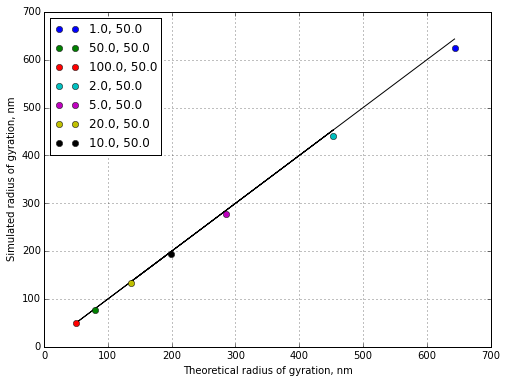

In [6]:
figure, ax = plt.subplots(1,1, figsize = (8,6))

theoryLine = [value for value in theoryResults.values()]
ax.plot(theoryLine, theoryLine, 'k')
differences = {}
for key in simResults.keys():
    c, lp = key
    ax.plot(theoryResults[key], simResults[key], 'o', label = '%r, %r' % (c, lp))
    
    differences[key] = simResults[key] - theoryResults[key]

diffX = [x for x,y in sorted(differences.keys())]
diffY = [y for x,y in sorted(differences.items())]

plt.xlabel('Theoretical radius of gyration, nm')
plt.ylabel('Simulated radius of gyration, nm')
plt.legend(loc = 'best')
plt.grid(True)
plt.show()
#plt.savefig('lp50_varyc.pdf')

Now, I'm plotting the mean radius of gyration vs. the simulated packing ratio. We can see a clear underestimate in this value for smaller packing ratios, i.e. for longer chains. This demonstrates the bias introduced from the truncation of the cosine series.

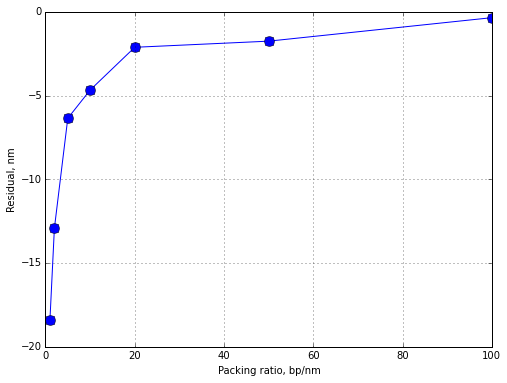

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (8,6))
ax.plot(diffX, diffY, '-o', markersize=10)

plt.grid(True)
plt.xlabel('Packing ratio, bp/nm')
plt.ylabel('Residual, nm')

Most of the parameter space we've simulated in this work lies at packing ratios above 20 bp/nm. So, using this as a rough lower bound, what is the longest length of chain we can reliably simulate?

$$c = 20 \; bp/nm, \; N = 25 \; kbp$$

$$\frac{25000 \; bp}{20 \; bp/nm} \times \left( 2.5 \; segments/nm\right) = 3125 \; segments$$

So we have an upper bound of roughly **3125 segments**, corresponding to a point where there is a bias in the mean radius of gyration of about -2.5 nm from the theoretical value.

### Does sample size affect the bias?

Now let's see whether increasing the number of chains generated improves bias.

In [30]:
segmentLength = 2.5 # segments / nm
numPaths = 100000
databaseName = 'sampleTest_HelaL_' + rw.dateStr

collectorParams = {
    'numPaths'      : numPaths,
    'pathLength'    : numBP['Hela L'] * np.ones(numPaths),
    'linDensity'    : np.asarray(list(zip(*params))[0]),
    'persisLength'  : np.asarray(list(zip(*params))[1]),
    'segConvFactor' : segmentLength,
    'nameDB'        : databaseName,
    'locPrecision'  : 0,
    'fullSpecParam' : True}

myCollector = rw.WLCCollector(**collectorParams)

Density: 1.0, Persistence length: 50.0
Mean of all path Rg's: 624.886708
Density: 2.0, Persistence length: 50.0
Mean of all path Rg's: 440.866987
Density: 5.0, Persistence length: 50.0
Mean of all path Rg's: 276.609160
Density: 10.0, Persistence length: 50.0
Mean of all path Rg's: 192.866743
Density: 20.0, Persistence length: 50.0
Mean of all path Rg's: 132.745040
Density: 50.0, Persistence length: 50.0
Mean of all path Rg's: 77.718092
Density: 100.0, Persistence length: 50.0
Mean of all path Rg's: 49.163189


In [31]:
chains = rw_helpers.loadModel(['sampleTest_HelaL_' + rw.dateStr])

# Remove the bumped data
for key, value in chains.items():
    chains[key] = value[0]

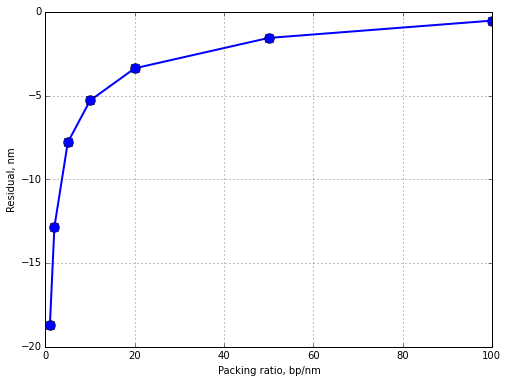

In [35]:
# simulations
simResults = dict(zip(chains.keys(),
                      np.mean(list(chains.values()), axis = 1)))

# theory
theoryResults = dict(zip(chains.keys(),
                         [rw_helpers.WLCRg(c, lp, numBP['Hela L']) for c, lp in chains.keys()]))

theoryLine = [value for value in theoryResults.values()]
ax.plot(theoryLine, theoryLine, 'k')
differences = {}
for key in simResults.keys():
    c, lp = key    
    differences[key] = simResults[key] - theoryResults[key]

diffX = [x for x,y in sorted(differences.keys())]
diffY = [y for x,y in sorted(differences.items())]

fig, ax = plt.subplots(1, 1, figsize = (8,6))
ax.plot(diffX, diffY, '-o', markersize=10, linewidth=2)

plt.grid(True)
plt.xlabel('Packing ratio, bp/nm')
plt.ylabel('Residual, nm')
plt.savefig('fig-simulation_accuracy-HelaL.pdf')

No, it doesn't affect the bias, it only gives more precise results. How bad is the bias for Hela S?

In [36]:
# Now try Hela S
segmentLength = 2.5 # segments / nm
numPaths = 100000
databaseName = 'sampleTest_HelaS_' + rw.dateStr

collectorParams = {
    'numPaths'      : numPaths,
    'pathLength'    : numBP['Hela S'] * np.ones(numPaths),
    'linDensity'    : np.asarray(list(zip(*params))[0]),
    'persisLength'  : np.asarray(list(zip(*params))[1]),
    'segConvFactor' : segmentLength,
    'nameDB'        : databaseName,
    'locPrecision'  : 0,
    'fullSpecParam' : True}

myCollector = rw.WLCCollector(**collectorParams)

Density: 1.0, Persistence length: 50.0
Mean of all path Rg's: 393.723808
Density: 2.0, Persistence length: 50.0
Mean of all path Rg's: 276.376577
Density: 5.0, Persistence length: 50.0
Mean of all path Rg's: 171.218686
Density: 10.0, Persistence length: 50.0
Mean of all path Rg's: 117.173983
Density: 20.0, Persistence length: 50.0
Mean of all path Rg's: 77.755131
Density: 50.0, Persistence length: 50.0
Mean of all path Rg's: 41.827380
Density: 100.0, Persistence length: 50.0
Mean of all path Rg's: 24.185396


In [37]:
chains = rw_helpers.loadModel(['sampleTest_HelaS_' + rw.dateStr])

# Remove the bumped data
for key, value in chains.items():
    chains[key] = value[0]

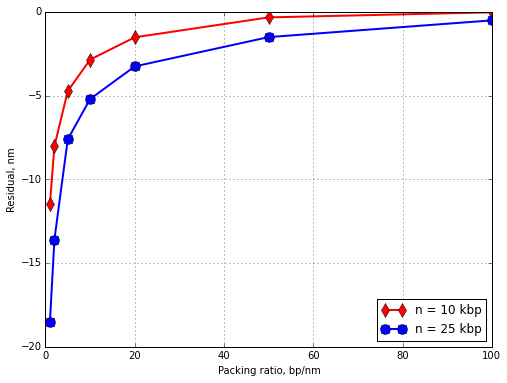

In [48]:
# simulations
simResults = dict(zip(chains.keys(),
                      np.mean(list(chains.values()), axis = 1)))

# theory
theoryResults = dict(zip(chains.keys(),
                         [rw_helpers.WLCRg(c, lp, numBP['Hela S']) for c, lp in chains.keys()]))

# plot with Hela L (because I don't want to rerun the long Hela L simulation)
# I estimated the values from the above graph
diffYL = [-18.5, -13.6,-7.6,-5.2,-3.25,-1.5,-0.5]

theoryLine = [value for value in theoryResults.values()]
ax.plot(theoryLine, theoryLine, 'k')
differences = {}
for key in simResults.keys():
    c, lp = key    
    differences[key] = simResults[key] - theoryResults[key]

diffX = [x for x,y in sorted(differences.keys())]
diffY = [y for x,y in sorted(differences.items())]

fig, ax = plt.subplots(1, 1, figsize = (8,6))
ax.plot(diffX, diffY, '-rd', markersize=10, linewidth=2, label = 'n = 10 kbp')
ax.plot(diffX,diffYL, '-bo', markersize=10, linewidth=2, label = 'n = 25 kbp')

plt.grid(True)
plt.xlabel('Packing ratio, bp/nm')
plt.ylabel('Residual, nm')
plt.ylim((-20,0))
plt.legend(loc='lower right')
plt.savefig('fig-simulation_accuracy.pdf')

## Determining the radius of gyration from a constellation of localizations

We'd next like to know how accurate the estimate in R<sub>g</sub> is when using the constellation of localizations as an estimate. In other words, how close is R<sub>g</sub>(polymer) to R<sub>g</sub>(localizations)?

In [10]:
# USER-INPUTS
# Packing ratio [bp/nm] persistence lengths [nm] to simulate (MODIFY THESE);
# Segment length to use [segments/nm]
# Number of chains to simulate for each downsample
params = [(50,50)]
segmentLength = 2.5
numOfChains = 100000

# Convert parameters to chain units (lengths in segments)
paramsChainUnits = [rw_helpers.convToChainUnits(segmentLength, c, lp, numBP['Hela L']) for c, lp in params]

# Initialize the polymer (initial parameters don't matter)
myChain = rw.WormlikeChain(100,1)

Now, simulate a number of chains for each pair of parameter values and downsample the chains over a range of downsampling factors. This means we'll keep only a subset of segments in the polymer which would correspond to our labeled localizations.

In [11]:
numDownsamples = np.arange(10, 210, 10)
dsResults = {}

# This relies on a one-to-one correspondance between values in the params list and values in the paramsChainUnits list.
for paramCtr, currChainParam in enumerate(paramsChainUnits):
    # Preallocate the results array
    dsResults[params[paramCtr]] = np.zeros((numOfChains, len(numDownsamples)))
    
    for dsCtr, numDS in enumerate(numDownsamples):
        # Divide by segmentLength to convert back to nm units
        # simChains returns an array of radii of gyration computed from the ensemble
        dsResults[params[paramCtr]][:, dsCtr] = rw_helpers.simChains(currChainParam,
                                                                     numOfChains,
                                                                     lambda x: rw_helpers.downsampleChain(x, numDS)) / segmentLength

Now we have a number of chains from the same ensemble, some of which have been downsampled more than others. We want compute the mean radius of gyration from the downsampled ensembles and the variance and plot this as a function of the number of samples in the chain.

In [12]:
meanRg = {}
varRg = {}
for parameter in params:
    meanRg[parameter] = np.mean(dsResults[parameter], axis = 0)
    varRg[parameter] = np.var(dsResults[parameter], axis = 0)
    
# for comparing to theoretical mean with first element in params list
theoryRg = np.repeat(rw_helpers.WLCRg(params[0][0], params[0][1], numBP['Hela L']), len(numDownsamples))

# for the simulated, fully-sampled mean with first element in params list
simRgNum = 100000
simRg = np.mean(rw_helpers.simChains(paramsChainUnits[0], simRgNum) / segmentLength, axis = 0)
simRg = np.repeat(simRg, len(numDownsamples))



In [13]:
# Simulate the full variance
simVarRg = np.var(rw_helpers.simChains(paramsChainUnits[0], simRgNum) / segmentLength, axis = 0)
simVarRg = np.repeat(simVarRg, len(numDownsamples))

#### Mean radius of gyration vs. number of points in downsample

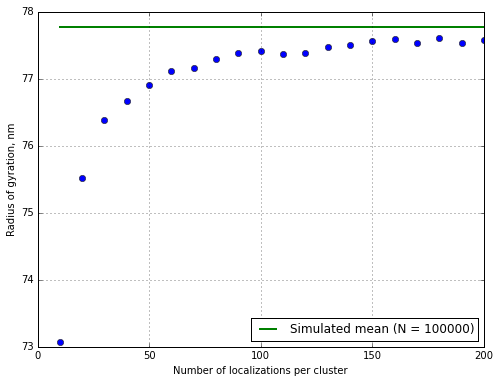

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (8,6))

ax.plot(numDownsamples, meanRg[(50,50)], 'o')
#ax.plot(numDownsamples, theoryRg, 'k', linewidth=2, label = 'Theoretical mean')
ax.plot(numDownsamples, simRg, 'g', linewidth=2, label = 'Simulated mean (N = %i)' % simRgNum)

plt.grid(True)
plt.xlabel('Number of localizations per cluster')
plt.ylabel('Radius of gyration, nm')
plt.legend(loc = 'best')
#plt.show()
plt.savefig('downsampling_noTheory.pdf')

#### Mean radius of gyration vs. number of points in downsample

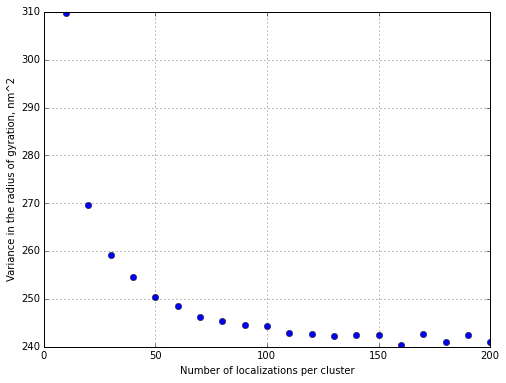

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (8,6))

ax.plot(numDownsamples, varRg[(50,50)], 'o')

plt.grid(True)
plt.xlabel('Number of localizations per cluster')
plt.ylabel('Variance in the radius of gyration, nm^2')
#plt.show()
plt.savefig('downsampling_var.pdf')

In [16]:
np.save('meanRg.npy', meanRg)
np.save('theoryRg.npy', theoryRg)
np.save('varRg.npy', varRg)

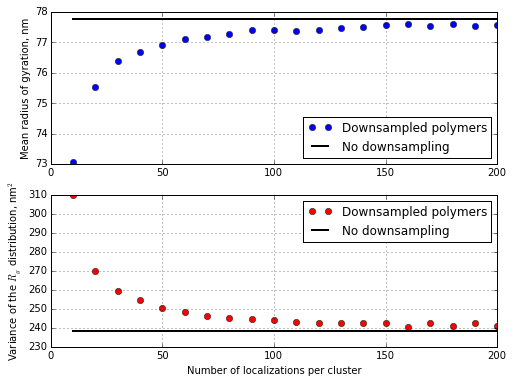

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8,6))

ax1.plot(numDownsamples, meanRg[(50,50)], 'o', label = 'Downsampled polymers')
ax1.plot(numDownsamples, simRg, 'k', linewidth=2, label = 'No downsampling')
ax1.grid(True)
ax1.set_ylabel('Mean radius of gyration, nm')
ax1.legend(loc = 'best')

ax2.plot(numDownsamples, varRg[(50,50)], 'ro', label = 'Downsampled polymers')
ax2.plot(numDownsamples, simVarRg, 'k', linewidth=2, label = 'No downsampling')
ax2.grid(True)
ax2.set_ylabel(r'Variance of the $R_g$ distribution, nm$^2$')
ax2.legend(loc = 'best')

plt.xlabel('Number of localizations per cluster')
plt.savefig('downsampling_subplots.pdf')
plt.savefig('downsampling_subplots.svg')